<a href="https://colab.research.google.com/github/CriptoQuant/Informacion-Cuantica/blob/main/CorrecionErrores(3%2C1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Circuito corrector de 3 quits para detectar y corregir la amplitud de 1 qubit

In [ ]:
!pip install qiskit ipywidgets
!pip install pylatexenc
!pip install matplotlib
!pip install qiskit-aer

In [ ]:

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from qiskit import *
from qiskit_aer import Aer
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, XGate

In [104]:
def aplicarErrorAmplitud (qubiterror):
  matrizError = np.identity(8)

  # Aplicar la puerta X en el qubit correcto
  for i in range(8):
    if (i >> qubiterror) % 2 == 0:  # Si el bit en esa posición es 0
        j = i | (1 << qubiterror)  # Cambia el bit a 1
        matrizError[i, i], matrizError[j, j] = 0, 0
        matrizError[i, j], matrizError[j, i] = 1, 1

  #print(matrizError)
  return matrizError

In [101]:
def corregirErrorAmplitud (deteccionError):

  print("Síndrome detectado:", deteccionError)

  # Obtener el resultado con mayor probabilidad
  outcome = max(deteccionError, key=deteccionError.get)

  # Mapeo de síndromes a qubits con error
  sindrome_a_qubit = {
      "011": 0,  # Error en qubit 0
      "001": 1,  # Error en qubit 1
      "010": 2   # Error en qubit 2
  }

  # Si no detecta sindrome, no se hace nada (devuelve matriz identidad)
  if outcome not in sindrome_a_qubit:
    print("No se detectó error o síndrome desconocido.")
    return np.eye(8)  # Devolver matriz identidad (sin cambios)

  # Obtener el qubit con error según el síndrome detectado
  qubit_error = sindrome_a_qubit[outcome]
  print(f"Error corregido en el qubit {qubit_error}")

  # Aplicar la misma lógica de `aplicarErrorAmplitud` para corregir el error
  matrizCorreccion = np.eye(8)
  for i in range(8):
    if (i >> qubit_error) & 1 == 0:  # Detecta si el bit en la posición `qubit_error` es 0
      j = i | (1 << qubit_error)   # Intercambiar el bit correspondiente
      matrizCorreccion[[i, j], [j, i]] = 1
      matrizCorreccion[[i, j], [i, j]] = 0

  return matrizCorreccion

In [108]:
n=5
qc = QuantumCircuit(n,3)

#qc.x(0)
qc.barrier()

#Aplicar las puertas CNOT a los qubits
for i in range (n-3):
  qc.cx(0,i+1)

qc.barrier()

#Error
# Generador de errores, input = qubit objetivo para el error
identity_3q = aplicarErrorAmplitud(0)
unitary_error_gate = UnitaryGate(identity_3q, label="Error")
qc.append(unitary_error_gate, range (n-2))
qc.barrier()

#qc.x(2)
#qc.barrier()

# Calcular el síndrome
qc.cx(0,3)
qc.cx(1,3)
qc.cx(0,4)
qc.cx(2,4)

qc.barrier()

# Mediciones de qubits ancilla
qc.measure(3,0)
qc.measure(4,1)
qc.barrier()

sim = Aer.get_backend('qasm_simulator')

my_circuit = transpile(qc, sim)
job = sim.run(my_circuit)

result = job.result()
counts = result.get_counts()
print("Resultados qubits ancila:", counts)

# Corrección del error
matriz_correccion = corregirErrorAmplitud(counts)
unitary_correction_error_gate = UnitaryGate(matriz_correccion, label="Correccion Error")
qc.append(unitary_correction_error_gate, range (n-2))
qc.barrier()


# Mediciones de los qubits
qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)
qc.barrier()



my_circuit1 = transpile(qc, sim)
job1 = sim.run(my_circuit1)

result1 = job1.result()
counts1 = result1.get_counts()
print("Resultados despues de correccion:", counts1)

Resultados qubits ancila: {'011': 1024}
Síndrome detectado: {'011': 1024}
Error corregido en el qubit 0
Resultados despues de correccion: {'000': 1024}


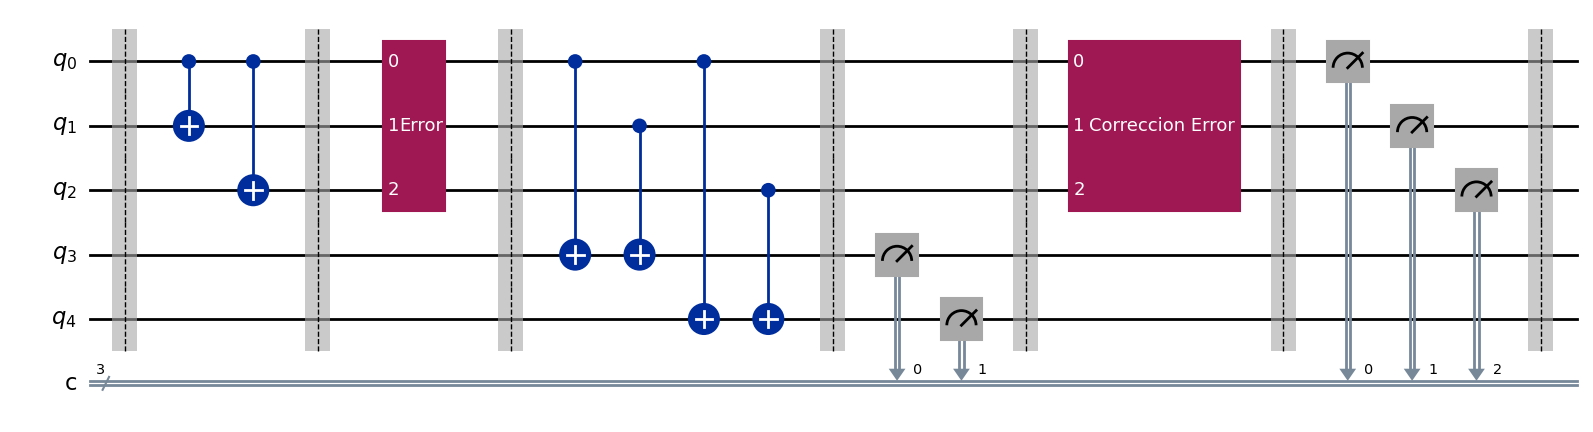

In [109]:

# Dibujar el circuito
qc.draw('mpl')

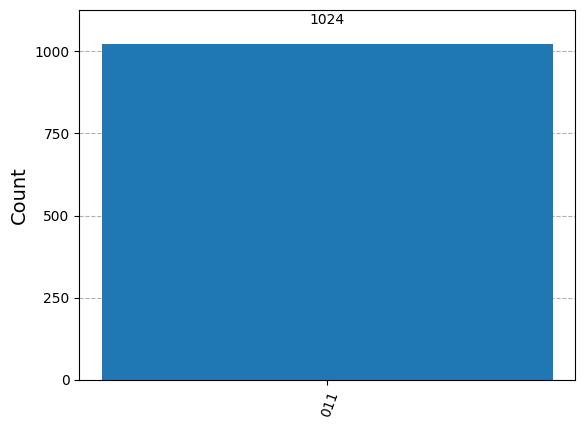

In [110]:
plot_histogram(counts)


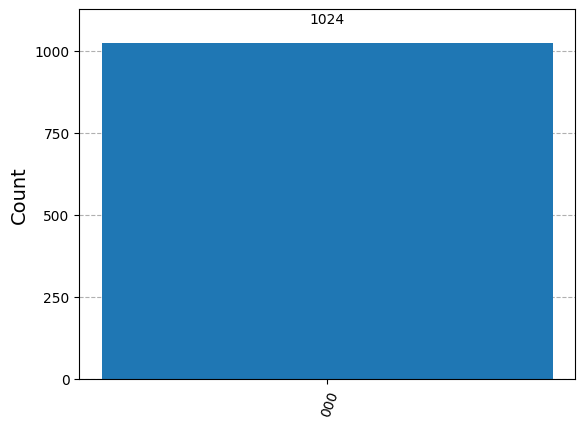

In [111]:
plot_histogram(counts1)